In [1]:
from dasr.models.facebook_denoiser import get_pretrained_model
import os
from hydra import initialize, compose
from hydra.utils import instantiate
import torch

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 4

/usr/local/lib/python3.10/dist-packages/hydra/core/plugins.py:225: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/usr/local/lib/python3.10/dist-packages/hydra/plugins/__init__.py)
  warnings.warn(


In [2]:
best = "/home/docker_current/dasr/checkpoints/2023-11-18-22-20-29_wav2vec+pretrained_dns64 (freeze encoder), SNR=10, train[0:3000] CTC/best.pth"

In [3]:
device = "cuda"

default_denoiser = get_pretrained_model("dns64")

our_denoiser = get_pretrained_model("dns64")
our_denoiser.load_state_dict(torch.load(best, map_location=device)["model_state_dict"])
our_denoiser.to(device), default_denoiser.to(device)
;

''

In [4]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [5]:
batch = next(iter(test_loader))
batch

{'clean_audios': tensor([[-1.8190e-12, -5.4570e-12, -2.9104e-11,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-6.1062e-16, -1.9429e-16,  1.3878e-16,  ..., -3.6380e-12,
          -7.2760e-12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-7.2760e-12, -3.6380e-12,  9.0949e-13,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-3.4925e-10, -4.0745e-10, -1.1642e-10,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.1642e-10,  1.4552e-11, -8.0036e-11,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 'noise_audios': tensor([[ 0.0139, -0.0067,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0186, -0.0012,  0.0014,  ..., -0.0120,  0.0131,  0.0157],
         [-0.0012,  0.0139,  0.0002,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0020,  0.0074,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0020, -0.00

In [6]:
speech = batch["noise_audios"].to(device)
clear_speech = batch["clean_audios"].to(device)

attention_mask = batch["noise_attention_masks"].to(device)

our_denoisy_speech = our_denoiser(speech).squeeze(1)
default_denoisy_speech = default_denoiser(speech).squeeze(1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 10.75 GiB total capacity; 8.72 GiB already allocated; 91.94 MiB free; 8.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from IPython.display import Audio, display

ind = 3

n_nonmask_elem = int(attention_mask[ind].sum())
# n_nonmask_elem = 40000

# Display the clear speech audio
display(Audio(clear_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), rate=16000))

# Display the original noisy speech audio
display(Audio(speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), rate=16000))

# Display the denoised speech audio
display(Audio(our_denoisy_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), rate=16000))

# Display the denoised speech audio
display(Audio(default_denoisy_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), rate=16000))


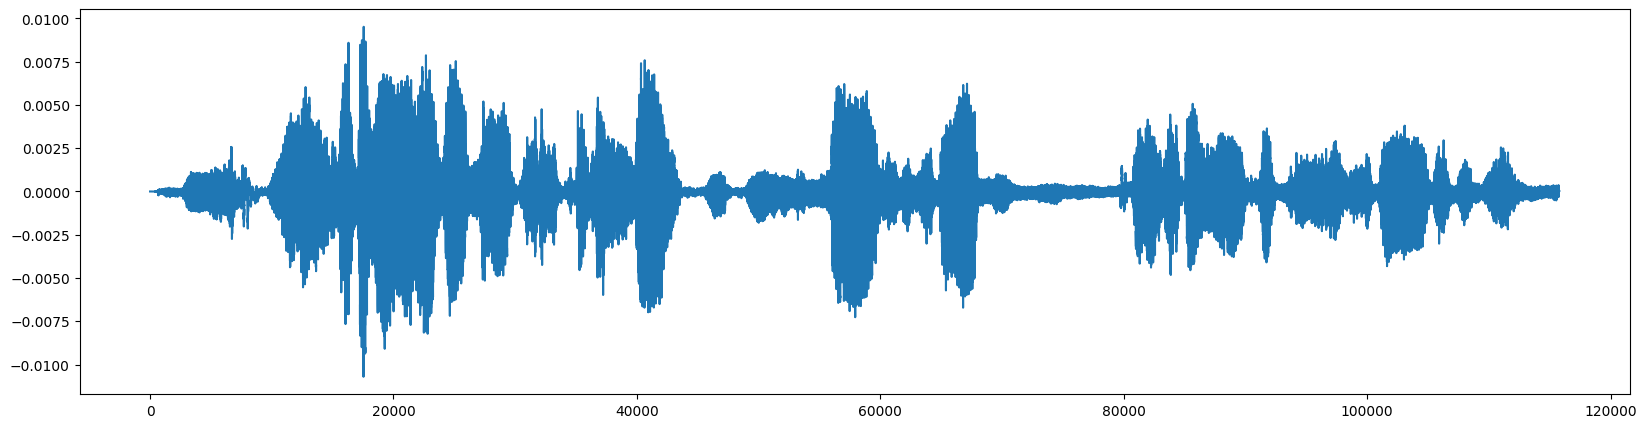

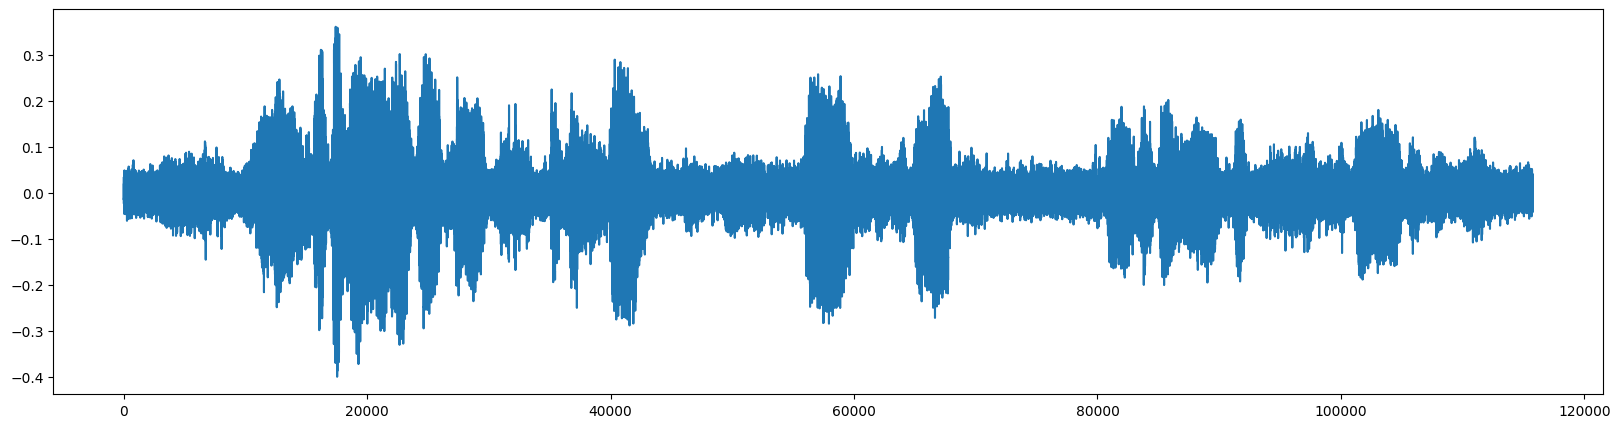

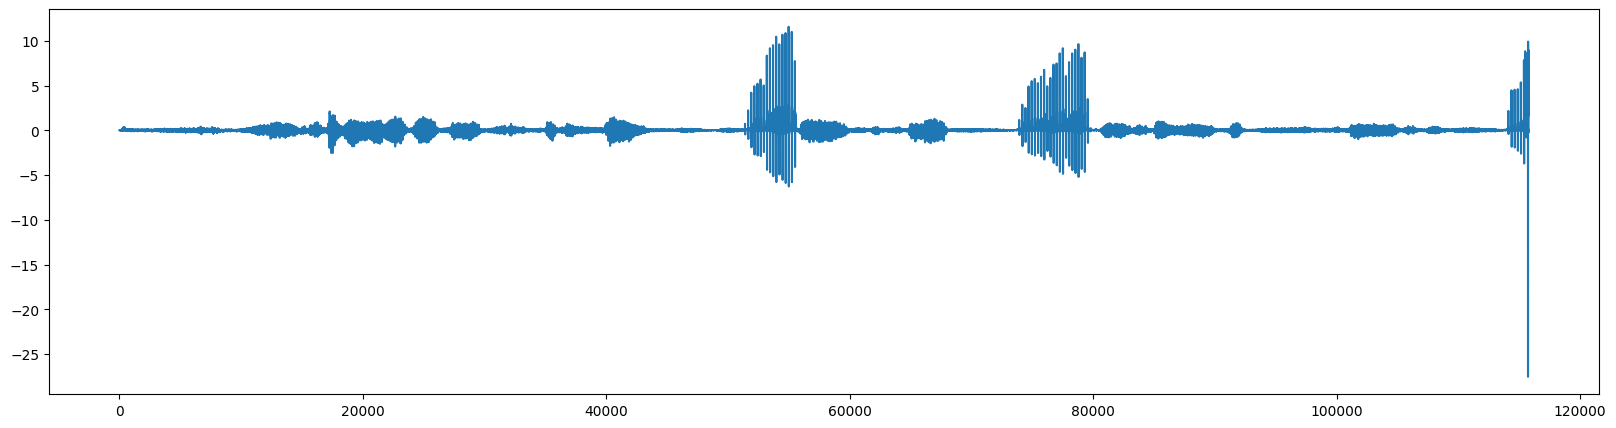

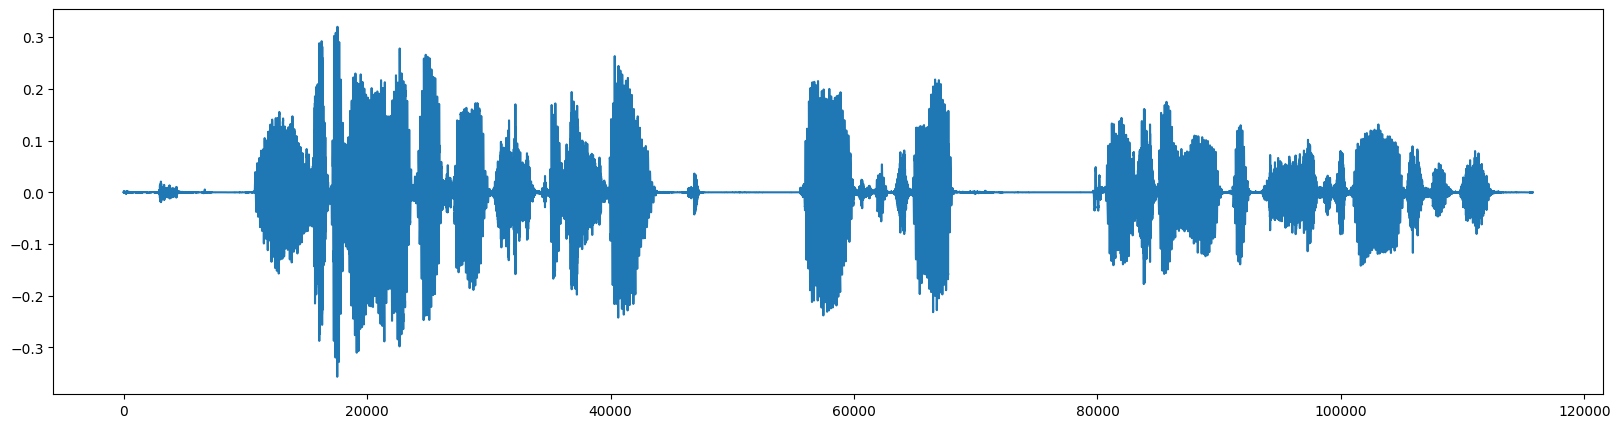

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(clear_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), label="Clear speech")

plt.figure(figsize=(20, 5))
plt.plot(speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), label="Noisy speech")

plt.figure(figsize=(20, 5))
plt.plot(our_denoisy_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), label="Denoised speech")

plt.figure(figsize=(20, 5))
plt.plot(default_denoisy_speech[ind][0:n_nonmask_elem].cpu().detach().numpy(), label="Default denoised speech")